In [35]:
from typing import Annotated, Literal,Sequence,TypedDict
from langchain import hub
from langchain_core.messages import AIMessage,HumanMessage,BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from typing import Any
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda,RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


In [36]:
from langchain_huggingface import HuggingFaceEmbeddings

In [37]:
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [38]:
from langchain_groq import ChatGroq

In [39]:
llm=ChatGroq(
    model_name="Gemma2-9b-It")

In [40]:
llm.invoke("What is the capital of France?")

AIMessage(content='The capital of France is **Paris**. 🇫🇷  \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 16, 'total_tokens': 31, 'completion_time': 0.027272727, 'prompt_time': 0.001910856, 'queue_time': 0.24976335400000002, 'total_time': 0.029183583}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--95b74bf1-05b9-4633-9828-d500e51522ab-0', usage_metadata={'input_tokens': 16, 'output_tokens': 15, 'total_tokens': 31})

In [41]:
urls=[
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/"
]

In [42]:
docs = [WebBaseLoader(url).load() for url in urls]

In [43]:
docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'title': "Reward Hacking in Reinforcement Learning | Lil'Log", 'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for real-world deployment of more autonomous use

In [44]:
docs[2][0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/',
 'title': "Prompt Engineering | Lil'Log",
 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.',
 'language': 'en'}

In [45]:
docs[0][0].metadata

{'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/',
 'title': "Reward Hacking in Reinforcement Learning | Lil'Log",
 'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for real-world deployment of more autonomous use cases of AI model

In [46]:
doc_list =[item for sublist in docs for item in sublist]

In [47]:
doc_list

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'title': "Reward Hacking in Reinforcement Learning | Lil'Log", 'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for real-world deployment of more autonomous use 

In [48]:
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100,chunk_overlap=5)

In [49]:
doc_splits=text_splitter.split_documents(doc_list)

In [50]:
doc_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-11-28-reward-hacking/', 'title': "Reward Hacking in Reinforcement Learning | Lil'Log", 'description': 'Reward hacking occurs when a reinforcement learning (RL) agent exploits flaws or ambiguities in the reward function to achieve high rewards, without genuinely learning or completing the intended task. Reward hacking exists because RL environments are often imperfect, and it is fundamentally challenging to accurately specify a reward function.\nWith the rise of language models generalizing to a broad spectrum of tasks and RLHF becomes a de facto method for alignment training, reward hacking in RL training of language models has become a critical practical challenge. Instances where the model learns to modify unit tests to pass coding tasks, or where responses contain biases that mimic a user’s preference, are pretty concerning and are likely one of the major blockers for real-world deployment of more autonomous use 

In [51]:
vector_store=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",
    embedding=embeddings
)

In [52]:
retriever=vector_store.as_retriever()

In [53]:
retriever_tool = create_retriever_tool(
    retriever,
    "retriev_blog_post",
    "retrieve blog_posts""search and return information about Lilian weng blog posts on Extrinsic Hallucinations in LLMs, prompt engineering and Reward Hacking in Reinforcement "
)

In [54]:
tools=[retriever_tool]

In [55]:
class AgentState:
    messages : Annotated[Sequence[BaseMessage],add_messages]


In [56]:
class grade(BaseModel):
    binary_score :str =Field(description="Relevance score 'yes' or 'no'")


In [57]:
def AI_ASISTANT(state:AgentState):
    print("---CALL AGENT--")
    messages= state["messages"]
    llm_with_tool = llm.bind_tools(tools)
    response= llm_with_tool.invoke(messages)
    return {"messages":[response]}



In [58]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages=state["messages"]
    question=messages[0].content
    last_message=messages[-1]
    docs=last_message.content

    prompt = hub.pull("rlm/rag-prompt")

    rag_chain = prompt | llm | StrOutputParser()

    response = rag_chain.invoke({"context": docs, "question":question})

    return{"messages":[response]}


In [59]:
def grade_documents(state:AgentState):
    llm_with_structure_op = llm.with_structured_output(grade)

    prompt = PromptTemplate(
        template=
        """You are a grader assessing relevance of retrieved document to a user question. \n\n
        Here is the retrieved document: \n \n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question , grade it as "related" or "not related" \n\n
        Give a binary score "yes" or "no" score to indicate whether the document is relevant to the question or not \n\n
        """,
        input_variables=["context","question"]
    )

    chain = prompt | llm_with_structure_op

    messages =state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question":question, "context":docs})

    score = scored_result.binary_score

In [60]:
def rewrite(state):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg=[
        HumanMessage(
            content=f""" \n
            Look at the input and try to reason about the underyling semantic intent / meaning. \n
            Here is the initial question:
            \n ------ \n
            {question}
            \n ------ \n
            Formulate an improved question:"""
        )
    ]

    #Grader
    response= llm.invoke(msg)
    return {"messages":[response]}



In [61]:
workflow = StateGraph(AgentState)
workflow.add_node("ai_assistant", AI_ASISTANT)
retrieve=ToolNode([retriever_tool])
workflow.add_node("retriever", retrieve)
workflow.add_node("rewriter", rewrite) 
workflow.add_node("generate", generate)

In [62]:
workflow.add_edge(START,"ai_assistant")
workflow.add_conditional_edges("ai_assistant",tools_condition,
                               {"tools":"retriever",
                                END:END})

In [63]:
workflow.add_conditional_edges("retriever",
                               grade_documents,
                               {"rewriter":"rewriter","generate":"generate"})

In [64]:
workflow.add_edge("generate",END)

In [65]:
workflow.add_edge("rewriter","ai_assistant")

In [66]:
app =workflow.compile()

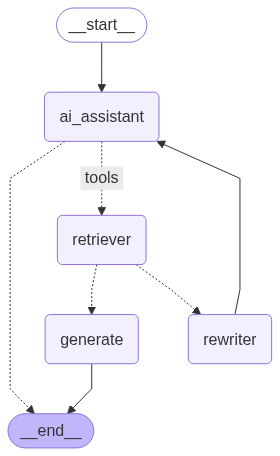

In [68]:
from IPython.display import display, Image

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))

except Exception as e:
    print("Error displaying graph:", e)

In [67]:
app.invoke("")

InvalidUpdateError: Expected dict, got 
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE